In [1]:
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

import pandas as pd
import geopandas as gpd
import glob
import rasterio
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils

  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.10.0
    Uninstalling geopandas-0.10.0:
      Successfully uninstalled geopandas-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [7]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'

ZONAL_STATS_DICT = {'ZONE_NAME':'','ZONE_FN':'','REGION_NAME':'','REGION_FN':'','RASTER_NAME':'','RASTER_FN':''}
ZONAL_STATS_DICT_LIST = [
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'boreal_na',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson',
            'REGION_SEARCH_COL':'REALM',
            'REGION_SEARCH_STR':'NA',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev06_v1c.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev03_v1c.gpkg',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
]


In [8]:
ZONAL_STATS_DICT = ZONAL_STATS_DICT_LIST[3]
ZONAL_STATS_DICT

{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev06_v1c.gpkg',
 'REGION_NAME': 'above',
 'REGION_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev03_v1c.gpkg',
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': 'Region',
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt',
 'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'}

### Select regions of interest with a general box; make a list of individual region geodataframes
* indiv region gdfs are needed so you can look over them

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 0 to 133
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   HYBAS_ID   33 non-null     int64   
 1   NEXT_DOWN  33 non-null     int64   
 2   NEXT_SINK  33 non-null     int64   
 3   MAIN_BAS   33 non-null     int64   
 4   DIST_SINK  33 non-null     float64 
 5   DIST_MAIN  33 non-null     float64 
 6   SUB_AREA   33 non-null     float64 
 7   UP_AREA    33 non-null     float64 
 8   PFAF_ID    33 non-null     int64   
 9   SIDE       33 non-null     object  
 10  LAKE       33 non-null     int64   
 11  ENDO       33 non-null     int64   
 12  COAST      33 non-null     int64   
 13  ORDER      33 non-null     int64   
 14  SORT       33 non-null     int64   
 15  geometry   33 non-null     geometry
dtypes: float64(4), geometry(1), int64(10), object(1)
memory usage: 4.4+ KB


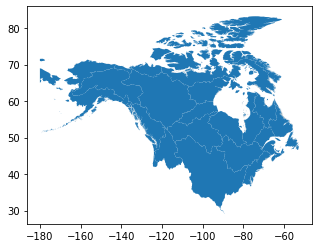

In [9]:
vector_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).cx[-180:-45,45:90]
vector_gdf.info()
vector_gdf.plot()

geoms_list = []
zone_name_list = []
poly_list = []
gdf_list = []
zone_field_name = 'HYBAS_ID'

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        #gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)
        poly_list.append(gpd.GeoSeries(geom))
        gdf_list.append(gpd.GeoDataFrame(geometry=gpd.GeoSeries(geom), crs=vector_gdf.crs))

In [ ]:
zone_name_list[20]

## Update the dictionary with region of interest

{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev06_v1c.gpkg',
 'REGION_NAME': 'HYBAS_L03_7030022250',
 'REGION_FN':                                             geometry
 0  MULTIPOLYGON (((-82.02639 53.05833, -82.02978 ...,
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': None,
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt',
 'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'}

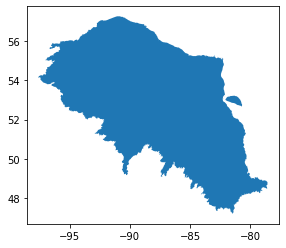

In [13]:
# Example for a single region
IDX=24
gdf_list[IDX].plot()

ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[IDX], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"HYBAS_L03_{zone_name_list[IDX]}" })
ZONAL_STATS_DICT

## Loop over regions of interest, returning zonal stats for all zones in region

In [ ]:
%%time
for i in range(0, len(gdf_list)):
    ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[i], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"HYBAS_L03_{zone_name_list[i]}" })
    z = ExtractUtils.get_raster_zonalstats(ZONAL_STATS_DICT, DEBUG=False)
    ax = z.plot('median', cmap='viridis', legend=True, vmin=0, vmax=75)
    print(ax)

In [6]:
files = glob.glob('/projects/my-public-bucket/analyze_agb/output/zonal*.geojson')
files

['/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030014250.202204220248.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030014930.202204220249.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030014940.202204220320.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030021430.202204220359.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030022240.202204220429.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030022250.202204220543.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030024600.202204220628.geojson',
 '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030027430.202204220706.geojson',


In [7]:
z = pd.concat([gpd.read_file(f) for f in files])
#z = gpd.read_file('/projects/shared-buckets/nathanmthomas/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030009570.202204221343.geojson')
#'/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030014250.202204220248.geojson'

DriverError: '/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_7030014250.202204220248.geojson' not recognized as a supported file format.

In [ ]:
import geopandas as gpd
zonal_lev06 = pd.concat([gpd.read_file(f) for f in files])
#zonal_lev06.shape

In [ ]:
above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]
with rasterio.open(ZONAL_STATS_DICT['RASTER_FN'], mode='r') as src:
    raster_crs = src.crs
zonal_lev06.set_crs(raster_crs, allow_override=True, inplace=True)
zonal_lev06.crs

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [25, 10]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
canada = world[world.name == 'Canada']
canada_alaska = pd.concat([alaska, canada])
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')

ax = canada_alaska.cx[-170:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', linewidth=0.25)
ax = boreal_gdf.cx[-180:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', ax=ax)
zonal_lev06.to_crs(above_domain_gdf.crs).plot('total_Mg', cmap='viridis', legend=True, vmin=0, vmax=1000, ax=ax)


In [ ]:
z.hist('median', bins=100)

In [ ]:
hybas_lev06 = pd.concat([gpd.read_file(f) for f in glob.glob('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_lev03_v1c.shp')])
hybas_lev06.plot(column='LAKE')
hybas_lev06.to_file('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev03_v1c.gpkg', driver='GPKG')

In [ ]:
import zipfile
zipdir = '/projects/my-public-bucket/analyze_agb/hydrobasins'
files = glob.glob(f'{zipdir}/*_as_*.zip')
for f in files:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall(zipdir)